# **PROJECT - Adversarial Examples in ”pure python”**

Thisi is the simplified version of the code that satisfies all the tasks required for the project. At the end we add an updated and more sofisticated version for further works and some observations that we invistigated beyond the scope of the project.

In [ ]:

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf

#LOAD MNIST DATASET:


(train_images, train_y), (test_images, test_y)= tf.keras.datasets.mnist.load_data()
X_train=np.zeros((60000,784))
X_test=np.zeros((60000,784))

#Let's reduce the 28x28 image into a 784 vector
def flatten(input):

    flattened_vector = []
    for row in input:
        flattened_vector.extend(row)
    return flattened_vector

def deFlatten(flattened_vector, num_rows, num_cols):

    image = []
    for i in range(num_rows):
        start_index = i * num_cols
        end_index = start_index + num_cols

        row = flattened_vector[start_index:end_index]
        image.append(row)

    return image

#IN ORDER TO WORK WITH OUR NEURAL NETWORK WE NEED TO TRANSFORM OUR 28X28 INPUT (MATRIX) INTO 784 INPUT (VECTOR)
for i in range (60000):
  X_train[i]=flatten(train_images[i])

for i in range (10000):
  X_test[i]=flatten(test_images[i])

#TO WORK WITH NUMBER IN 0,1
X_train = X_train / 255.0
X_test = X_test / 255.0


n_mnist_train=len(train_images)      #60000
n_mnist_test=len(test_images)        #10000


# tranforms train_y in vector of len=10 with 0/1 : hot encoding
nb_classes = len(np.unique(train_y)) #10 THE CLASSES ARE THE SAME ALSO FOR test_y OF COURSE
one_hot_targets_train = np.eye(nb_classes)[train_y] #Matrix  (60000, 10)

one_hot_targets_test =  np.eye(nb_classes)[test_y]

#Function to create a dense layer: gives us the weights and the biases to use in that layer.
def create_dense_layer(n_input,n_output):
  weights=np.random.randn(n_output,n_input)/np.sqrt(n_input)# de v.a. normales de moyenne 0 et variance "1/n_input"
  biases=np.zeros((n_output,1)) #vecteur colonne nul de n_output composantes
  return weights, biases



**Change of activation function**

The function $ x \to \frac{x+ \sqrt{(x^2+a^2)}}{2}$ for small values of a is a good approximation for the Rectified Linear Unit (ReLU) function because it behaves similarly.
In fact, ReLU returns x if x is positive, and 0 otherwise.
When a is small, the term $ a^2 $ becomes negligible compared to $x^2$.

This approximation is a good approximation of the ReLU function since the following aspects:
- Derivative: the derivative of this function is: $x \to \frac{1}{2}\left(1 + \frac{x}{\sqrt{x^2 + a^2}}\right)$
- Monocity: this function is always non-decreasing like ReLU and for $x<0$ the derivative tends to 0 very fast and for x>0 the derivative tends to 1
- In x=0 ReLu = 0 and the Approx_function = $\frac{a}{2} \approx 0 $ when $|a|\ll 1$

In [ ]:
def ReLU(input_array):
  return np.maximum(0,input_array)

def approx_ReLU(input_array):
  a=10**-4
  return (input_array + np.sqrt(input_array**2+a**2))/2

def dev_approx_ReLU(x):
  return 0.5*(1 + x/(np.sqrt(x**2 + 10**(-8))))


def softmax(x):
  x=x-np.max(x) #Substract by the maximum in order to avoid problems of overflow.
  return np.exp(x)/np.sum(np.exp(x))




dim1,dim2,dim3,dim4=784, 64, 64, 10 #784 is the dimension of the input and #is the dimension of the output and they are fixed. While the dimension of the hidden layer is arbitrary
weights1, biases1 = create_dense_layer(dim1, dim2)
weights2, biases2 = create_dense_layer(dim2,dim3)
weights3, biases3 = create_dense_layer(dim3,dim4)
losses=[]



In [ ]:
alpha=10/n_mnist_train #LEARNING RATE

# TRAINING  LOOP

epochs=1 #If we want to increment the accuracy of our model we can increase the number of epochs.

for i in range(epochs):
  for iter in range(n_mnist_train):

#INPUT
      Y0 = X_train[[iter],:].T

# FORWARD STEP:

      # dense layer 1
      Y1tilde = weights1@Y0+biases1
      Y1 = approx_ReLU(Y1tilde)  # activation 1: ReLU

      # dense layer 2
      Y2tilde = weights2@Y1+biases2
      Y2 =  approx_ReLU(Y2tilde)   # activation 2: ReLU

      # dense layer 3
      Y3tilde = weights3@Y2+biases3

      #final computations of the fwd step
      label=one_hot_targets_train[[iter],:].T
      q=softmax(Y3tilde) #q gives (0.1 , 0.4, .... , 0.2) a vector in which there are the probabilities to be in a certain class

#LOSSES COMPUTATION: we use Categorical _ Cross Entropy

      loss_val= -np.sum(label*np.log(q))
      losses.append(loss_val)


#Optimizer: SGD [Stochastic Gradient Descend with Back Propagation]

      dY3tilde=q-label #first two derivative

      # gradient on parameters layer 3
      dweights3 = dY3tilde@Y2.T
      dbiases3 = dY3tilde

      # gradient on values activation 2
      dY2 = weights3.T@dY3tilde
      dY2tilde = dev_approx_ReLU(Y2tilde) * dY2


      # gradient on parameters layer 2
      dweights2 = dY2tilde@Y1.T
      dbiases2 = dY2tilde

      # gradient on values activation 1
      dY1 = weights2.T@dY2tilde
      dY1tilde = dY1*dev_approx_ReLU(Y1tilde)

      # gradient on parameters layer 1
      dweights1 = dY1tilde@Y0.T
      dbiases1 = dY1tilde


#Update weights and biases
      weights1 -= alpha*dweights1
      biases1 -= alpha*dbiases1
      weights2 -= alpha*dweights2
      biases2 -= alpha*dbiases2
      weights3 -= alpha*dweights3
      biases3 -= alpha*dbiases3

#PLOTTING the losses

#plt.loglog(losses)
plt.plot(losses)
plt.title('losses')
plt.pause(0.1)

print(losses)


In [ ]:
#EVALUATE ACCURACY

qresults=[] #contains the predicitons results
count=0 #counts the number of good answers


for nn in range(n_mnist_test): #nn è il numero di immagini test (ogni immagine è una array da 784 valori)

#INPUT
    Y0 = X_test[[nn],:].T
# dense layer 1
    Y1tilde = weights1@Y0 + biases1
    Y1 = approx_ReLU(Y1tilde)  # activation 1: ReLU
# dense layer 2
    Y2tilde = weights2@Y1 + biases2
    Y2 =  approx_ReLU(Y2tilde)   # activation 2: ReLU
# dense layer 3
    Y3tilde = weights3@Y2 + biases3
#OUTPUT using SoftMAX

    q=softmax(Y3tilde)
    qresults.append(q.copy())


    if np.all([q[test_y[nn],0] > p for jj,p in enumerate(q[:,0]) if jj != test_y[nn]]):
      #np.all() restituisce True se tutti gli elementi di un array soddisfano una certa condizione.
        count=count+1


print('accuracy=',np.round(100*count/n_mnist_test,2),"\b%")


plt.hist(np.argmax(qresults,axis=1),alpha = 0.5) #alpha is just for the transparency of the hist
plt.hist(test_y,alpha = 0.5)
plt.legend(['predictions','true values'])
plt.title('predictions')

In [ ]:
#Creating a perturbated image:


def create_perturbated_image(ind,eps):
  #INPUT OF NN
  Y0 = X_test[[ind],:].T

  # dense layer 1
  Y1tilde = weights1@Y0+biases1
  Y1 = approx_ReLU(Y1tilde)  # activation 1: Approx_ReLU

  # dense layer 2
  Y2tilde = weights2@Y1+biases2
  Y2 =  approx_ReLU(Y2tilde)   # activation 2: Approx_ReLU

  # dense layer 3
  Y3tilde = weights3@Y2+biases3

  #final computations of the fwd step
  label=one_hot_targets_test[[ind],:].T
  q=softmax(Y3tilde) #q gives a vector in which there are the probabilities to be in a certain class

  #LOSSES COMPUTATION
  loss_val= -np.sum(label*np.log(q))
  losses.append(loss_val)


  #SGD
  dY3tilde= q - label

  # gradient on parameters layer 3
  dweights3 = dY3tilde@Y2.T
  dbiases3 = dY3tilde

  # gradient on values activation 2
  dY2 = weights3.T@dY3tilde
  dY2tilde = dev_approx_ReLU(Y2tilde) * dY2


  # gradient on parameters layer 2
  dweights2 = dY2tilde@Y1.T
  dbiases2 = dY2tilde

  # gradient on values activation 1
  dY1 = weights2.T@dY2tilde
  dY1tilde = dY1*dev_approx_ReLU(Y1tilde)

  # gradient on parameters layer 1
  dweights1 = dY1tilde@Y0.T
  dbiases1 = dY1tilde


#GRADIENT
  dY0 = weights1.T@dY1tilde #Gradient of the output wrt input ( useful when I have to perturbate)

  adv_X = X_test[[ind],:] + eps * np.sign(dY0.T)
  adv_X_plot = X_test[ind,:] + eps * np.sign(dY0[:,0])

  return adv_X,adv_X_plot

In [ ]:
#EVALUATION of an REAL_IMAGE:

t=0 #variable that counts how many images the NN classifies differently before and after perturbation
w=0 #variable that counts how many images the NN misclassified before perturbation
z=0 #variable that counts how many images the NN classifies wrong before perturbation and after it classify in a different way
index=[] #register the index of different classified images
eps=0.009 #variable to control the magnitude of our perturbation

images=[] #contains the real images classified differently
images_pert=[] #contains the perturbated images classified differently

confidences=[]
confidences_pert=[]

guesses=[]
guesses_pert=[]

for i in range(100):

  #INPUT
  image=deFlatten(X_test[i,:],28,28)

  Y0 = X_test[[i],:].T

  # dense layer 1
  Y1tilde = weights1@Y0 + biases1
  Y1 = approx_ReLU(Y1tilde)  # activation 1: Approx_ReLU

  # dense layer 2
  Y2tilde = weights2@Y1 + biases2
  Y2 =  approx_ReLU(Y2tilde)   # activation 2: Approx_ReLU

  # dense layer 3
  Y3tilde = weights3@Y2 + biases3

  #OUTPUT using SoftMAX
  q=softmax(Y3tilde)
  guess=np.argmax(q)
  confidence = np.max(q)*100


  #EVALUATION of an PERTURBATED_IMAGE:

  #INPUT
  adv_X, adv_X_plot=create_perturbated_image(i,eps)

  image_1=deFlatten(adv_X_plot,28,28)

  Y0 = adv_X.T
  # dense layer 1
  Y1tilde = weights1@Y0 + biases1
  Y1 = approx_ReLU(Y1tilde)  # activation 1: Approx_ReLU
  # dense layer 2
  Y2tilde = weights2@Y1 + biases2
  Y2 =  approx_ReLU(Y2tilde)   # activation 2: Approx_ReLU
  # dense layer 3
  Y3tilde = weights3@Y2 + biases3
  #OUTPUT using SoftMAX

  q_1=softmax(Y3tilde)
  guess_1=np.argmax(q_1)
  confidence_1 = np.max(q_1)*100

  if guess!=test_y[i]:
    w=w+1


  if guess != guess_1:
    t=t+1

    index.append(i)
    images.append(image)
    images_pert.append(image_1)
    confidences.append(round(confidence,2))
    confidences_pert.append(round(confidence_1,2))
    guesses.append(guess)
    guesses_pert.append(guess_1)



  if guess!=test_y[i] and guess!= guess_1:
    z=z+1



fig, axs = plt.subplots(2, len(index),sharex=False, sharey=True, figsize=(10,4))

for j in range(len(index)):
  axs[0,j].imshow(images[j],cmap='gray')
  axs[0,j].set_title(f"Label: {guesses[j]} \n  {confidences[j]}%")

  axs[1,j].imshow(images_pert[j], cmap='gray')
  axs[1,j].set_title(f"Label: {guesses_pert[j]} \n  {confidences_pert[j]}%")

  axs[0,j].get_xaxis().set_visible(False)
  axs[0,j].get_yaxis().set_visible(False)
  axs[1,j].get_xaxis().set_visible(False)
  axs[1,j].get_yaxis().set_visible(False)


plt.tight_layout()
plt.show()

print(f'There are: {t} different classified images')
print(f'There are: {w}  images that the NN classiffies wrong even before perturbation')
print(f'There are: {z}  images that the NN classiffies wrong before perturbation and then classifies in a different way')
print('The misclassified images corresponds to this index in the MNIST test dataset: ', index)

In [ ]:
from tabulate import tabulate

# Definire i dati per la tabella come una lista di tuple
data = [
    ("Accuracy of the Model ", "Epsilon", "Different classification", "Wrong classification of Real Image", "Wrong classification of Real images \n between the ones that are classified differently.  ", "Index of images in test set \n classified differently    "),
    (f"{np.round(100*count/n_mnist_test,2)}%", eps, t, w, z, index),

]
# Stampare la tabella utilizzando la funzione tabulate
print(tabulate(data, headers="firstrow", tablefmt="grid"))


# Here we insert the Updated Version for further observations and studies.

In [ ]:
#Took 6.5min to run on my computer from start to finish
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(31416)

Helper Functions

In [ ]:
#Returns a neural network dense layer. Copied from the iris class example
def create_dense_layer(n_input,n_output):
    weights=np.random.randn(n_output,n_input)/np.sqrt(n_input)# de v.a. normales de moyenne 0 et variance "1/n_input"
    biases=np.zeros((n_output,1)) #vecteur colonne nul de n_output composantes
    return weights, biases

#Math functions. Self explanatory

def ReLU(input_array):
   return np.maximum(0,input_array)

def dev_ReLU(input_array):
    return (input_array>0)*1

def approx_ReLU(input_array):
    a=10**-4
    return (input_array + np.sqrt(input_array**2+a**2))/2

def dev_approx_ReLU(x):
    return 0.5*(1 + x/(np.sqrt(x**2 + 10**(-8))))

def softmax(x):
    x=x-np.max(x)
    return np.exp(x)/np.sum(np.exp(x))

## Neural network class

We adapted the iris code by maintaing the code logic, but creating a more general neural network class so that changing the architecture can be done changing one line only.

In [ ]:
class NeuralNetwork():
    def __init__(self, nodes_layers, activation = "approx_relu"): #Takes as input a single list "nodes_layers" containing the number of neurons in each of the len(node_layers) layers, and the activation function code
        self.nr_layers = len(nodes_layers)
        self.nodes_layers = nodes_layers
        self.layers = [create_dense_layer(self.nodes_layers[i], self.nodes_layers[i+1]) for i in range(self.nr_layers-1)]
        self.weights = [x[0] for x in self.layers] #Separate weights and biases into diffferent arrays for easier implementation/debugging
        self.biases = [x[1] for x in self.layers]
        self.activation = activation #Activation function code. Right now only the codes "relu" and "approx_relu" make sense

    def activation_function(self, input_array): #Helper function
        if self.activation == "relu":
            return ReLU(input_array)
        elif self.activation == "approx_relu":
            return approx_ReLU(input_array)
        return "Activation code unknown."

    def activation_derivative(self, input_array): #Helper function
        if self.activation == "relu":
            return dev_ReLU(input_array)
        elif self.activation == "approx_relu":
            return dev_approx_ReLU(input_array)
        return "Activation code unknown."

    def loss_function(self, output, label): #Loss function (cross entropy)
        return -np.sum(label*np.log(output))

    def run(self, data): #Takes data as input, returns the values stored in the nodes (before and after activation function)
        data = data.reshape(-1, 1) #data formatting
        nodes_tilde = [np.zeros((size, 1)) for size in self.nodes_layers] #Values in nodes before activation
        nodes = [np.zeros((size, 1)) for size in self.nodes_layers] #Values in nodes after activation (or in the case of the last layer, softmax)
        nodes[0] = data #initialize first layer (convention: the input is passed as the first layer values AFTER activation)
        for i in range(self.nr_layers-2): #compute values for the hidden layers
            nodes_tilde[i+1] = self.weights[i]@nodes[i]+self.biases[i]
            nodes[i+1] = self.activation_function(nodes_tilde[i+1])

        #last layer:
        nodes_tilde[-1] = self.weights[self.nr_layers-2]@nodes[self.nr_layers-2]+self.biases[self.nr_layers-2]
        nodes[-1] = softmax(nodes_tilde[-1])

        return nodes_tilde, nodes


    def classify(self, data): #Takes data as input, returns the most likely value from the last layer and the corresponding "confidence"
        _, nodes = self.run(data)
        return np.argmax(nodes[-1]), np.max(nodes[-1])

    def derivatives(self, data, label): #Takes data and its corresponding label as input, computes all the derivatives with respect to node values (before and after activation), weights and biases
        data = data.reshape(-1, 1) #data formatting
        label = label.reshape(-1, 1) #data formatting
        dtilde = [np.zeros((size, 1)) for size in self.nodes_layers] #dtilde stores the derivative with respect to the node values before activation
        dnodes = [np.zeros((size, 1)) for size in self.nodes_layers] #dnodes stores the derivative with respect to the node values after activation
        dweights = [np.zeros(np.shape(x)) for x in self.weights] #dweights stores the derivative with respect to the weights
        dbiases = [np.zeros(np.shape(x)) for x in self.biases] #dbiases stores the derivative with respect to the biases
        nodes_tilde, nodes = self.run(data) #Run the nn on the given input

        dtilde[-1] = nodes[-1]-label #Formula from class
        for i in range(self.nr_layers-2, -1, -1): #For each layer i, starting with the second to last, compute the derivative with respect to the weights and biases between layer i and i+1, and to the values (before and after activation) of layer i
            dweights[i] = dtilde[i+1]@nodes[i].T
            dbiases[i] = dtilde[i+1]
            dnodes[i] = self.weights[i].T@dtilde[i+1] #NOTE: when i=0, dnodes[0] will contain the derivative with respect to the input, which we'll be useful when computing the adversarial example
            dtilde[i] = self.activation_derivative(nodes_tilde[i])*dnodes[i]

        return dweights, dbiases, dtilde, dnodes, nodes[-1] #return the last layer too (facilitates loss computation later)

    def sgd(self, data, label, lrate): #Takes data and label as input, and a learning rate. Updates the weights and biases according to the standard stochastic gradient descent algorithm (batch size = 1). Returns losses
        data = data.reshape(-1, 1) #data formatting
        label = label.reshape(-1, 1) #data formatting
        dweights, dbiases, _, _, last_layer = self.derivatives(data, label) #retrieve the derivatives wrt to weights and biases
        for i in range(self.nr_layers-1):
            self.weights[i] -= lrate*dweights[i] #Update the weights
            self.biases[i] -= lrate*dbiases[i] #Update the biases
        return self.loss_function(last_layer, label)

    def train(self, all_data, all_label, lrate, epochs, n_iter, proc = "linear"): #Training procedure. Takes in the full training set and corresponding labels, the learning rate, the number of epochs and iterations. proc should be "linear" if we go through each image exactly once in a linear fashion, or "random" if we choose an image at random, as in the iris code
        losses = []
        if proc=="linear":
            n_iter = len(all_data) #This condition must always be true so we train on each image exactly once per epoch
        for epoch in range(epochs):
            for iter in range(n_iter):
                if proc == "linear":
                    data = all_data[iter]
                    label = all_label[iter]
                else:
                    rand_index = np.random.choice(len(all_data)) #Choose an index at random
                    data = all_data[rand_index]
                    label = all_label[rand_index]
                losses.append(self.sgd(data, label, lrate)) #self.sgd returns the loss, and updates the weights and biases
                if iter % (n_iter//10) == 0:
                    print(f"Epoch {epoch+1} at {iter/n_iter*100}%")
            print(f"Epoch {epoch+1} at 100%")
        return losses #return the losses list



## Pre-process the MNIST dataset

In [ ]:
(train_images, train_y), (test_images, test_y)= tf.keras.datasets.mnist.load_data() #load the training and testing sets
X_train=np.zeros((60000,784, 1)) #there are 60000 28*28 images in the training set
X_test=np.zeros((10000,784, 1)) #there are 10000 28*28 images in the training set

In [ ]:
#We now reshape all the images so they can be cleanly passed as lists of length 784 to the first layer of the neural network
for i in range (60000):
    X_train[i] = train_images[i].reshape(-1, 1)

for i in range (10000):
    X_test[i] =  test_images[i].reshape(-1, 1)

In [ ]:
#We normalize all the images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
#We now tranform train_y in vector of len=10 with 0/1 : hot encoding
nb_classes = len(np.unique(train_y)) #10 THE CLASSES ARE THE SAME ALSO FOR test_y OF COURSE
one_hot_targets_train = np.eye(nb_classes)[train_y] #Matrix  (60000, 10)
one_hot_targets_test =  np.eye(nb_classes)[test_y]

## Choose the hyper-parameters for the neural network

In [ ]:
nodes_layers = [784, 64, 64, 10] #Choose the architecture for our neural network
lrate = 10/len(X_train) #Choose the learning rate
epochs = 1 #Choose the number of epochs
n_iter = len(X_train) #Choose the number of iterations per epoch (NOTE: doesn't matter when proc = "linear")
proc = "linear" #Choose the procedure type. Either "linear" or "random".

## Create and train the neural network

In [ ]:
NN = NeuralNetwork(nodes_layers) #Initialize the neural network

In [ ]:
losses = NN.train(X_train, one_hot_targets_train, lrate, epochs, n_iter, proc)

Epoch 1 at 0.0%
Epoch 1 at 10.0%
Epoch 1 at 20.0%
Epoch 1 at 30.0%
Epoch 1 at 40.0%
Epoch 1 at 50.0%
Epoch 1 at 60.0%
Epoch 1 at 70.0%
Epoch 1 at 80.0%
Epoch 1 at 90.0%
Epoch 1 at 100%


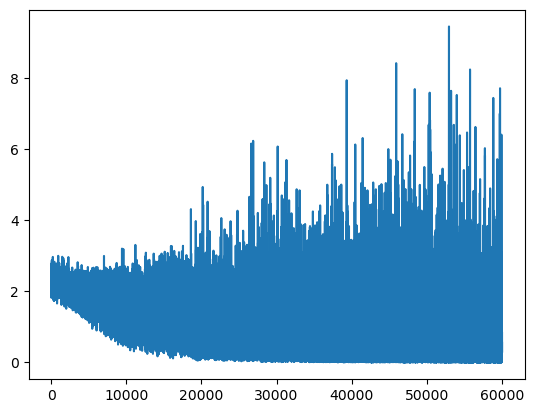

In [ ]:
plt.plot(losses) #Plot the losses

## Evaluating the accuracy of the neural network

In [ ]:
def evaluate_accuracy(nn, input, labels): #Takes in a neural network, and a data set (along with corresponding labels, NOT in one hot format) on which to evaluate the accuracy
    preds = [] #List that contains all the predictions made by the network
    cnt = 0
    for i in range(len(input)):
        prediction, _ = nn.classify(input[i])
        if prediction == labels[i]:
            cnt += 1
        preds.append(prediction)
    print(f"Accuracy on the given set: {cnt/len(input)*100}%")
    plt.hist(preds,alpha = 0.5) #alpha is just for the transparency of the hist
    plt.hist(labels,alpha = 0.5)
    plt.legend(['predictions','true values'])
    plt.title('predictions')

Accuracy on the given set: 87.32%


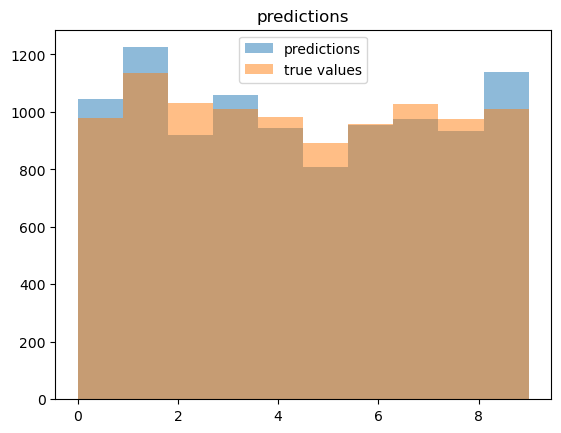

In [ ]:
evaluate_accuracy(NN, X_test, test_y) #Evaluate the accuracy of our trained model on our test set

Accuracy on the given set: 86.57833333333333%


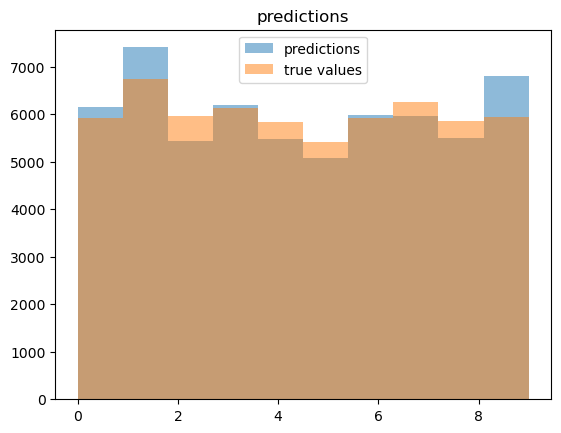

In [ ]:
evaluate_accuracy(NN, X_train, train_y) #Evaluate the accuracy of our trained model on the train set

## Creating the perturbed image

As per the report, the perturbed image is given by: $adv_x = x+\epsilon \cdot \text{sign}\left( \nabla_x J(\theta, x, y) \right)$

In [ ]:
def perturbed_image(nn, data, label, eps): #Takes in a neural network, the data of an image and its original label (one hot format), and the epsilon described above (the degree of perturbation)
    _, _, _, dnodes, _ = nn.derivatives(data, label) #We only care about the dnodes return value, since that is what contains the gradient wrt to the input
    adv_x = data+eps*np.sign(dnodes[0]) #dnodes[0] contains the desired gradient
    return adv_x

## A quick test

Text(0.5, 1.0, 'Real label: 4, NN label: 4 (51.24863913270289% confidence)')

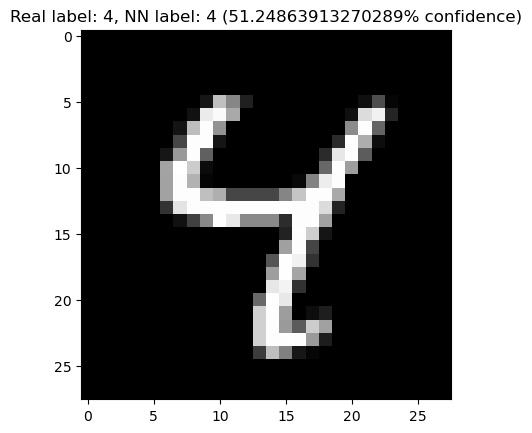

In [ ]:
class_before, confidence_before = NN.classify(X_test[6]) #Compute the classification by the NN before the perturbation
plt.imshow(X_test[6].reshape(28, 28), cmap='gray')
plt.title(f"Real label: {test_y[6]}, NN label: {class_before} ({confidence_before*100}% confidence)")

In [ ]:
perturbed_test = perturbed_image(NN, X_test[6], one_hot_targets_test[6], 0.01) #Create the perturbed image

Text(0.5, 1.0, 'NN label: 4 (39.194890955462746% confidence)')

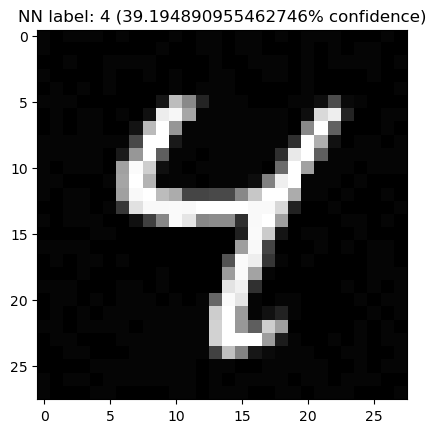

In [ ]:
class_after, confidence_after = NN.classify(perturbed_test) #Compute the classification by the NN after the perturbation
plt.imshow(perturbed_test.reshape(28, 28), cmap='gray')
plt.title(f"NN label: {class_after} ({confidence_after*100}% confidence)")

## Tests and analysis

### Finding the smallest $\epsilon$

#### Linear method

We create a function to find the smallest $\epsilon$ such that the perturbed image is incorrectly classified by the neural network.

In [ ]:
def smallest_eps_linear(nn, data, label, step = 0.001): #This function finds the smallest epsilon by starting at 0, and adding step each iteration until the classification changes. The label should be in one hot format
    if nn.classify(data)[0]!=np.argmax(label):
        print("Neural network already misclassifies image by default")
        return 0
    current_eps = 0
    perturbed = perturbed_image(nn, data, label, current_eps)
    while nn.classify(perturbed)[0]==np.argmax(label):
        current_eps += step #Add the step to the current eps
        perturbed = perturbed_image(nn, data, label, current_eps) #Test the new eps
    return current_eps #Returns the first eps (in increments of step) that produces a misclassification. The real smalles eps lies in the interval ]current_eps - step, current_eps]

In [ ]:
smallest_eps_linear(NN, X_test[6], one_hot_targets_test[6], 0.000001)

0.010525999999998719

#### Binary search method

We can implement a much more efficient binary search method if we know that the range of values for which the classification does not change is an interval of the form $[0, \epsilon_{min}]$ (see report).

We can test this hypothesis by trying the following check for every image: We compute which perturbations do not change the classification using epsilons in increments of $0.1$ in the interval $[0,1]$ (i.e. $0.1, 0.2, \cdots, 1$ and checking if the epsilons that work form a "discrete interval" - something of the form $\{0.1 \cdot i, i <= k\}$).

In [ ]:
def test_hypothesis(nn, data, label, step = 0.1):
    if nn.classify(data)[0]!=np.argmax(label):
        return -1 #We use the code -1 to identify an image that's already misclassified

    current_eps = 0
    same_label = [] #List that contains the values of epsilon for which the classification does not change
    while current_eps<=1:
        current_eps += step #Add the step to the current eps
        perturbed = perturbed_image(nn, data, label, current_eps) #Test the new eps
        if nn.classify(perturbed)[0]==np.argmax(label):
            same_label.append(current_eps) #Append to the list if the classification is correct

    if same_label==[] or abs(same_label[-1]/step - len(same_label))<0.01: #For example, [0.1, 0.2, 0.3] is a discrete interval so satisfies 0.3/0.1 == 3. [0.1, 0.6] does not satisfy this condition. It is easy to check that it is a sufficient and necessary condition. We use a numerical "equality" trick to avoid precision errors.
        return 1 #We use the code 1 to identify images for which we do have a discrete interval
    return 0 #We use the code 0 when we do not have a discrete interval

In [ ]:
#We now test the hypothesis for each image in the test set
hypothesis_results = []
for i in range(len(X_test)):
    hypothesis_results.append(test_hypothesis(NN, X_test[i], one_hot_targets_test[i], 0.025))
    if i%(len(X_test)//10)==0:
        print(i/len(X_test))
hypothesis_results = np.array(hypothesis_results)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [ ]:
len(hypothesis_results[hypothesis_results>=0])==len(hypothesis_results[hypothesis_results>0]) #check if the number of 0s is 0

True

The hypothesis seems to be true. We can then implement the binary search method to find the smallest $\epsilon$ (provided that it is smaller than $1$).

In [ ]:
def smallest_eps_bs(nn, data, label, precision = 0.00000001): #This function finds the smallest epsilon by halving the interval that contains eps_min in each iteration until its length is <= 2*precision. The label should be in one hot format
    if nn.classify(data)[0]!=np.argmax(label):
        #print("Neural network already misclassifies image by default")
        return 0

    left_bound = 0
    right_bound = 1
    while right_bound-left_bound>2*precision:
        middle = (left_bound+right_bound)/2.0
        perturbed = perturbed_image(nn, data, label, middle) #Test the new eps
        if nn.classify(perturbed)[0]==np.argmax(label): #If the midpoint is still classified correctly, the smallest epsilon lies to the right of the midpoint
            left_bound = middle
        else: #Otherwise it lies to the left
            right_bound = middle

    return (left_bound+right_bound)/2.0 #Returns the midpoint of the current interval which assures eps_min is at a distance of at most precision of the midpoint

In [ ]:
smallest_eps_bs(NN, X_test[6], one_hot_targets_test[6], 0.00001)

0.01052093505859375

### Finding the smallest $\epsilon$ for each test image

In [ ]:
def find_smallest_eps_set(nn, all_data, all_label): #Takes in the neural network, and the set of images and corresponding labels (in one hot format)
    smallest_eps = []
    for i in range(len(all_data)):
        smallest_eps.append(smallest_eps_bs(NN, all_data[i], all_label[i]))
        if i%(len(all_data)//10)==0:
            print(100*i/len(all_data))
    return np.array(smallest_eps)

In [ ]:
smallest_eps = find_smallest_eps_set(NN, X_test, one_hot_targets_test)


0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


In [ ]:
smallest_eps.max()

0.1654716059565544

In [ ]:
print(f"The number of images misclassified by default is {((smallest_eps==0)*1).sum()}") #Creates a 1/0 mask and finds the sum (1 represents default misclass)

The number of images misclassified by default is 1268


We can now investigate the distribution of these $\epsilon_{min}$. We only care about images which were not misclassified by default.

Text(0.5, 1.0, 'eps_min histogram')

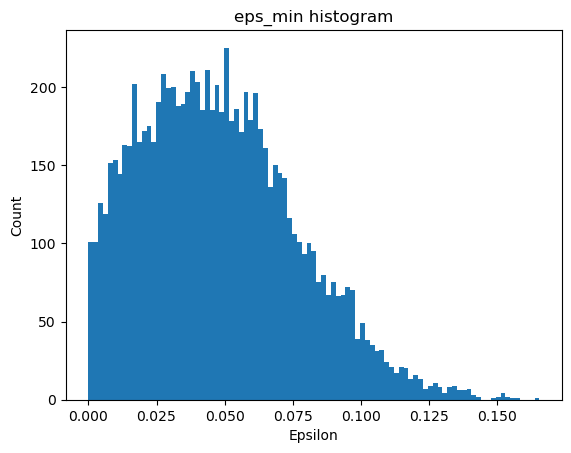

In [ ]:
plt.hist(smallest_eps[smallest_eps>0], bins = int(np.sqrt(len(smallest_eps[smallest_eps>0]))))
plt.xlabel("Epsilon")
plt.ylabel("Count")
plt.title("eps_min histogram")

Just for fun, we tried fitting a truncated normal distribution. This was done very much by hand, as finding the parameters of a truncated normal that match a given mean and standard deviation is a very non-trivial task (solving a system of 2 equations the involve the normal pdf and cdf).

Text(0.5, 1.0, 'eps_min histogram and truncated normal pdf')

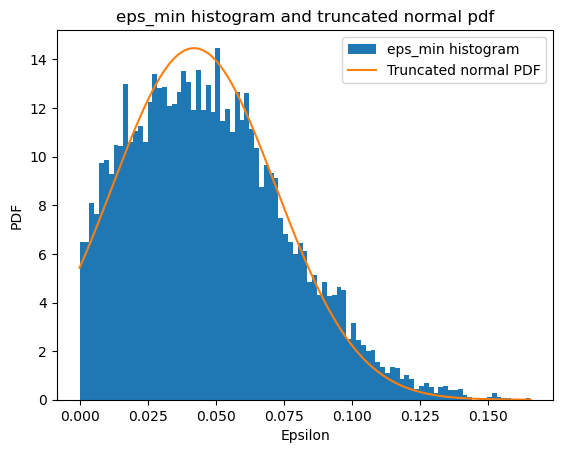

In [ ]:
from scipy.stats import truncnorm
clip_a = 0
clip_b = np.max(smallest_eps)
trunc_mean =0.042
trunc_std = 0.03

a, b = (clip_a-trunc_mean)/trunc_std, (clip_b-trunc_mean)/trunc_std
x_range = np.linspace(clip_a, clip_b,1000)
plt.hist(smallest_eps[smallest_eps>0], bins = int(np.sqrt(len(smallest_eps[smallest_eps>0]))), density=True, label="eps_min histogram")
plt.plot(x_range, truncnorm.pdf(x_range, a, b, loc = trunc_mean, scale = trunc_std), label="Truncated normal PDF")
plt.xlabel("Epsilon")
plt.ylabel("PDF")
plt.legend()
plt.title("eps_min histogram and truncated normal pdf")

In [ ]:
print(f"The mean of the distribution is {np.mean(smallest_eps[smallest_eps>0])}, while the median is {np.median(smallest_eps[smallest_eps>0])}")
print(f"The standard deviation is {np.std(smallest_eps[smallest_eps>0])}")

The mean of the distribution is 0.04793085444563308, while the median is 0.04534439742565155
The standard deviation is 0.02855581798204356


If we consider the threshold for an imperceptible perturbation to be $0.01$, we find that

In [ ]:
threshold = 0.01
print(f"The percentage of images which have an imperceptible perturbation is {100*((smallest_eps[smallest_eps>0]<=threshold)*1).sum()/len(smallest_eps[smallest_eps>0])}%")

The percentage of images which have an imperceptible perturbation is 7.821804855703161%


For a fixed $\epsilon$, it is easy to compute and plot as a function of $\epsilon$ the percentage of images which have misclassified $\epsilon$-perturbations.

In [ ]:
def percentage_perturbed_by_eps(NN, all_data, all_label, nr_points = 1000): #Takes in the neural network, and the set of images and corresponding labels (in one hot format), and the number of points to plot
    smallest_eps = find_smallest_eps_set(NN, all_data, all_label)
    smallest_eps = smallest_eps[smallest_eps>0] #We only care about images which do not have a 0-perturbation
    max_eps = np.max(smallest_eps) #Find the maximum smallest_eps, It'll be the endpoint of the x axis
    xaxis = np.linspace(0, max_eps, num = nr_points, endpoint=True) #Compute the x axis
    values = np.zeros(len(xaxis)) #Initialize values at each point in the x axis
    for i in range(len(xaxis)):
        values[i] = ((smallest_eps<=xaxis[i])*1).sum()/len(smallest_eps) #Compute the percentage of images which have a misclassified xaxis[i]-perturbation
    plt.plot(xaxis, values)
    plt.title("Fraction of images with an eps-perturbation, as a function of eps")
    plt.xlabel("Epsilon")
    plt.ylabel("Fraction")
    return xaxis, values


0.0


10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


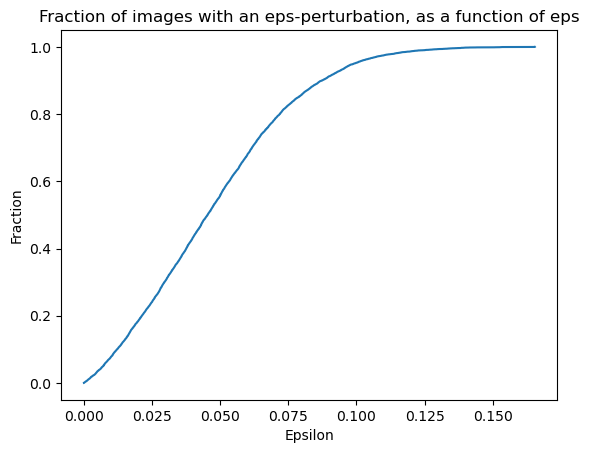

In [ ]:
xaxis, values = percentage_perturbed_by_eps(NN, X_test, one_hot_targets_test, 10000)

Just for fun, we use the same truncated normal as above and compare its cumulative density function:

Text(0, 0.5, 'Fraction')

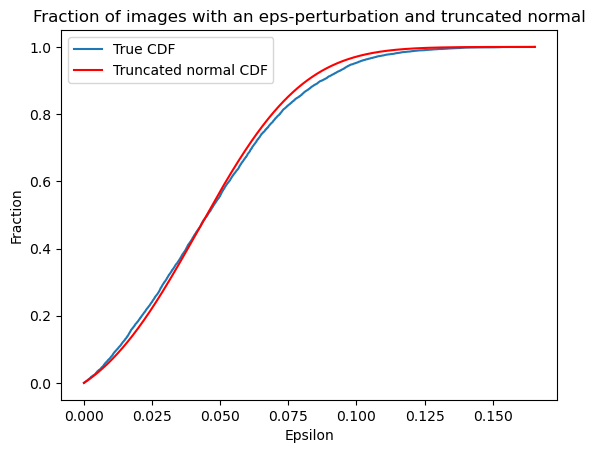

In [ ]:
from scipy.stats import truncnorm
clip_a = 0
clip_b = np.max(smallest_eps)
trunc_mean = 0.042
trunc_std = 0.03

a, b = (clip_a-trunc_mean)/trunc_std, (clip_b-trunc_mean)/trunc_std

plt.plot(xaxis, values, label="True CDF")
plt.plot(xaxis, truncnorm.cdf(xaxis, a, b, loc = trunc_mean, scale = trunc_std), label="Truncated normal CDF", color="red")
plt.plot()
plt.title("Fraction of images with an eps-perturbation and truncated normal")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Fraction")

### How does confidence change as a function of $\epsilon$?

In [ ]:
def compute_confidences(nn, data, label, nr_points=1000): #Takes in the neural network, an image and corresponding label (in one hot format), and the number of points to plot. Plots the confidence level of the correct label, and the confidence level of the most confident incorrect label as a function of eps
    correctclass = np.argmax(label)
    xaxis = np.linspace(0, 1, num = nr_points, endpoint=True) #Compute the x axis
    values_correct = np.zeros(len(xaxis)) #Initialize values of the correct class confidence
    values_misclass = np.zeros(len(xaxis)) #Initialize values of the misclass confidence
    mask = [True]*10 #Create a mask that removes the correct class
    mask[correctclass] = False
    for i in range(len(xaxis)):
        last_layer = nn.run(perturbed_image(nn, data, label, xaxis[i]))[1][-1] #run the neural network on the perturbed image and retrieve the last layer
        values_correct[i] = last_layer[correctclass] #get the confidence for the correct class
        values_misclass[i] = last_layer[mask].max() #get the confidence for the incorrect class
    plt.plot(xaxis, values_correct, color = "green", label = "Correct class confidence")
    plt.plot(xaxis, values_misclass, color = "red", label = "Incorrect class confidence")
    plt.axvline(x=smallest_eps_bs(nn, data, label), linestyle=':', label = "eps_min")
    plt.title("Evolution of misclass confidence as eps increases")
    plt.legend()
    plt.xlabel("Epsilon")
    plt.ylabel("Confidence")
    return xaxis, values_correct, values_misclass

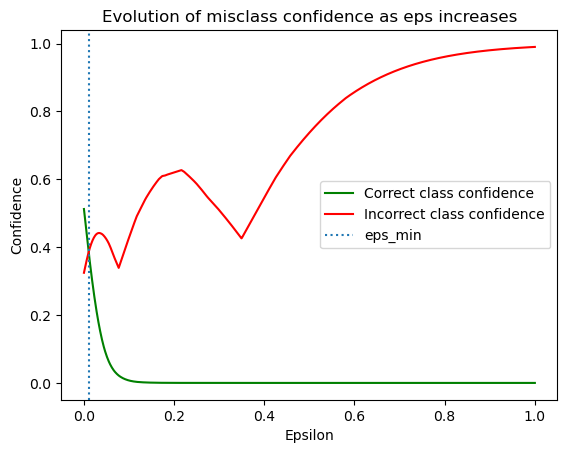

In [ ]:
xaxis, values_correct, values_misclass = compute_confidences(NN, X_test[6], one_hot_targets_test[6])

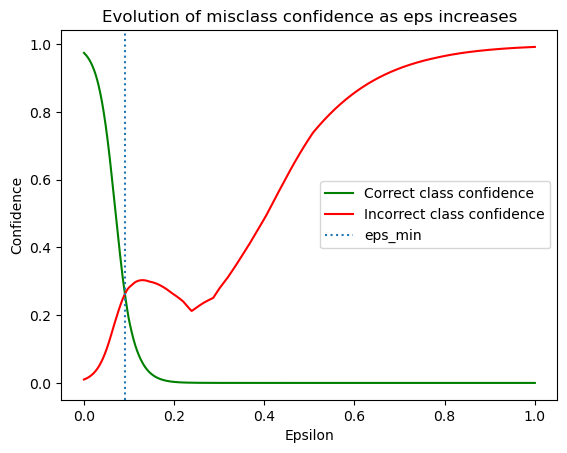

In [ ]:
xaxis, values_correct, values_misclass = compute_confidences(NN, X_test[314], one_hot_targets_test[314])

### Computing how many images have $\epsilon$-perturbations for a fixed $\epsilon$ in another way

In [ ]:
def count_perturbation(nn, all_data, all_label, eps): #Takes in the neural network, the set of images to count (and respective labels), and the fixed epsilon
    cnt = 0
    tot = 0
    for i in range(len(all_data)):
        data = all_data[i]
        label = all_label[i]
        if nn.classify(data)[0]!=np.argmax(label):
            continue
        perturbed_temp = perturbed_image(nn, data, label, eps)
        if nn.classify(perturbed_temp)[0]!=np.argmax(label):
            cnt += 1
        tot += 1
    return cnt, tot #return the count of images whose perturbations were misclassified, and the total amount of images which were not misclassified by default

In [ ]:
count, total = count_perturbation(NN, X_test, one_hot_targets_test, 0.01)

In [ ]:
count/total*100

7.821804855703161

The results match the previously implemented method. This is faster for a single $\epsilon$, but for testing many values it is much faster to use the method in the previous section which uses precomputation.

## Training the network on adversarial examples too

In [ ]:
def create_train_set(nn, all_data, all_label, eps): #This function extracts imperceptible adversarial examples from a data set, to later add to it
    new_data = []
    new_label = []
    for i in range(len(all_data)):
        if i%(len(all_data)//10)==0:
            print(i/len(all_data))
        data = all_data[i]
        label = all_label[i]
        if nn.classify(data)[0]!=np.argmax(label):
            continue
        perturbed_temp = perturbed_image(nn, data, label, eps)
        if nn.classify(perturbed_temp)[0]!=np.argmax(label): #If we find an adversarial image at the eps level, add it to the set with the CORRECT label
            new_data.append(perturbed_temp)
            new_label.append(label)
    return new_data, new_label


In [ ]:
X_adv, one_hot_targets_adv = create_train_set(NN, X_train, one_hot_targets_train, 0.01)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [ ]:
len(X_adv)

29344

We can see that 4147 adversarial examples were generated.

In [ ]:
#Creating a new test set with adversarial examples:
X_train_adv = np.append(X_train, np.array(X_adv), axis=0)
one_hot_targets_train_adv = np.append(one_hot_targets_train, np.array(one_hot_targets_adv), axis=0)

Now we create and train a new neural network on this set

In [ ]:
nodes_layers = [784, 64, 64, 10] #Choose the architecture for our neural network
lrate = 10/len(X_train_adv) #Choose the learning rate
epochs = 1 #Choose the number of epochs
n_iter_adv = len(X_train_adv) #Choose the number of iterations per epoch (NOTE: doesn't matter when proc = "linear")
proc = "linear" #Choose the procedure type. Either "linear" or "random".

In [ ]:
NN_adv = NeuralNetwork(nodes_layers)
losses_adv = NN_adv.train(X_train_adv, one_hot_targets_train_adv, lrate, epochs, n_iter_adv, proc)

Epoch 1 at 0.0%
Epoch 1 at 9.99955229226361%
Epoch 1 at 19.99910458452722%
Epoch 1 at 29.99865687679083%
Epoch 1 at 39.99820916905444%
Epoch 1 at 49.99776146131805%
Epoch 1 at 59.99731375358166%
Epoch 1 at 69.99686604584528%
Epoch 1 at 79.99641833810888%
Epoch 1 at 89.9959706303725%
Epoch 1 at 99.9955229226361%
Epoch 1 at 100%


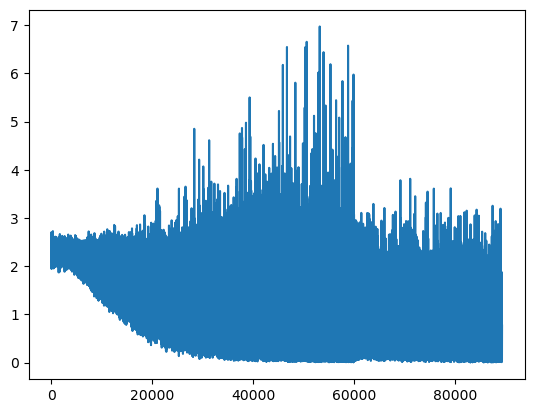

In [ ]:
plt.plot(losses_adv)

Accuracy on the given set: 87.92999999999999%


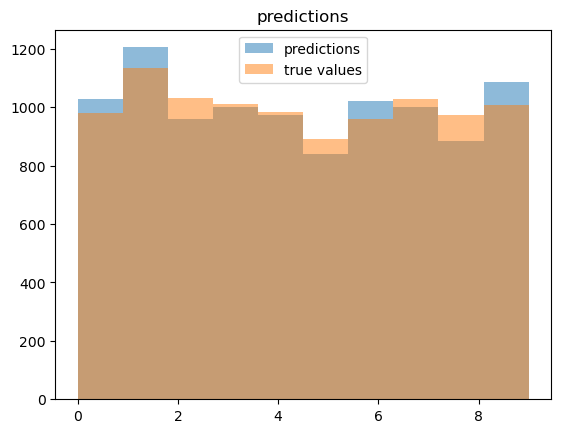

In [ ]:
evaluate_accuracy(NN_adv, X_test, test_y) #Evaluate the accuracy of our this model on the test set

We can see the accuracy is almost the same.

In [ ]:
count_adv, total_adv = count_perturbation(NN_adv, X_test, one_hot_targets_test, 0.01)

In [ ]:
count_adv/total_adv*100

7.926759922665756

We can see that it barely decreases the number of adversarial examples at the imperceptible level.